In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, Point
%matplotlib inline

Curate 1.88 million fired dataset from USDA. Discard those which occured outside of California.

In [42]:
fires = pd.read_csv('training_data/wild_fire_data/FPA_FOD_20170508.csv', low_memory=False)
fire_locations = fires[['LATITUDE', 'LONGITUDE']].copy()
fire_locations.head()

,LATITUDE,LONGITUDE
0,40.036944,-121.005833
1,38.933056,-120.404444
2,38.984167,-120.735556
3,38.559167,-119.913333
4,38.559167,-119.933056


In [43]:
empty = pd.Series([np.nan, np.nan ])
empty.index = ['LATITUDE', 'LONGITUDE']

def point_in_california(point):
    """ Takes point and returns point if in california"""
    coord = Point(point['LONGITUDE'], point['LATITUDE'])
    if coord.within(california) == True:
        return point
    else:
        return empty
    
def cull_points(points):
    keepers = points.apply(point_in_california, axis=1)
    return keepers
    
def parallelize(df, func, n_cores=14):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

california_fire_locations = parallelize(fire_locations, cull_points).dropna()
california_fire_locations.to_csv('training_data/wild_fire_data/california_wildfires.csv', index = None, header=True)

In [44]:
california_fire_locations.head()

,LATITUDE,LONGITUDE
0,40.036944,-121.005833
1,38.933056,-120.404444
2,38.984167,-120.735556
3,38.559167,-119.913333
4,38.559167,-119.933056


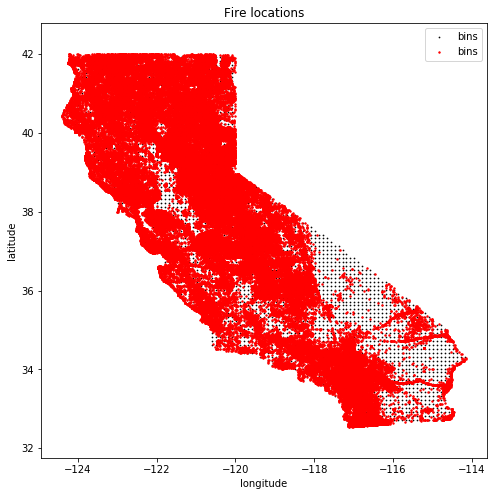

In [45]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x=keeper_bins['long'], y=keeper_bins['lat'], color='black', s=0.5, label='bins')
plt.scatter(x=california_fire_locations['LONGITUDE'], y=california_fire_locations['LATITUDE'], color='red', s=2, label='bins')
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Fire locations')
plt.legend()
plt.show()

Since we have many bins which do not contain a weather monitoring station, the next step is to fill in their values from the nearest station. First find the nearest station to each bin.

In [15]:
keeper_bins = pd.read_csv('spatial_data/california_bins.csv')
bin_array = np.column_stack([keeper_bins['long'], keeper_bins['lat']])
bin_array

array([[-117.08,   32.62],
       [-116.98,   32.62],
       [-116.88,   32.62],
       ...,
       [-120.28,   41.92],
       [-120.18,   41.92],
       [-120.08,   41.92]])

In [16]:
keeper_stations = pd.read_csv('weather_station_data/target_stations_in_california.csv')
station_array = np.column_stack([keeper_stations['longitude'], keeper_stations['latitude']])
station_array

array([[-119.505  ,   37.151  ],
       [-118.2    ,   34.446  ],
       [-120.792  ,   41.237  ],
       ...,
       [-123.358  ,   39.42767],
       [-123.355  ,   39.43056],
       [-120.233  ,   38.847  ]])

In [17]:
from scipy import spatial

station_tree = spatial.cKDTree(station_array)
dist, indexes = station_tree.query(bin_array)

In [18]:
nearest_station_names = []
for index in indexes:
    nearest_station_names.append(keeper_stations.iloc[index, 3])

In [19]:
keeper_bins['nearest_station_name'] = nearest_station_names
keeper_bins.head()

,lat,long,nearest_station_name
0,32.62,-117.08,SMG
1,32.62,-116.98,SMG
2,32.62,-116.88,SMG
3,32.62,-116.78,POT
4,32.62,-116.68,POT


Starting with the temperature dataset as a test case, now we will make an hourly time series spanning from 2006 to 2016 and assign each bin a temprature from it's nearest station each hour. 

In [2]:
temp_data = pd.read_csv('training_data/weather_data/TEMP.csv', low_memory=False)
temp_data.head()

,STATION_ID,DURATION,SENSOR_NUMBER,SENSOR_TYPE,DATE_TIME,OBS_DATE,VALUE,DATA_FLAG,UNITS
0,ACN,H,4,TEMP,20060101 2300,20060101 2300,54,,DEG F
1,ACN,H,4,TEMP,20060102 0000,20060102 0000,53,,DEG F
2,ACN,H,4,TEMP,20060102 0100,20060102 0100,53,,DEG F
3,ACN,H,4,TEMP,20060102 0200,20060102 0200,55,,DEG F
4,ACN,H,4,TEMP,20060102 0300,20060102 0300,55,,DEG F


In [5]:
temp_data = temp_data.drop(["DURATION", "SENSOR_NUMBER", "SENSOR_TYPE", "DATE_TIME", "DATA_FLAG", "UNITS"], axis=1)
temp_data = temp_data[temp_data.VALUE != '---']
temp_data['OBS_DATE'] = pd.to_datetime(temp_data['OBS_DATE'])
temp_data = temp_data.set_index(['STATION_ID', 'OBS_DATE'])
temp_data = temp_data.sort_index()
temp_data.head()

VALUE
STATION_ID OBS_DATE                 
ACN        2006-01-01 23:00:00    54
           2006-01-01 23:00:00    54
           2006-01-02 00:00:00    53
           2006-01-02 00:00:00    53
           2006-01-02 01:00:00    53

In [7]:
temp_data.drop_duplicates()

VALUE
STATION_ID OBS_DATE                   
ACN        2006-01-01 23:00:00      54
           2006-01-02 00:00:00      53
           2006-01-02 02:00:00      55
           2006-01-02 05:00:00      52
           2006-01-02 07:00:00      51
...                                ...
VRG        2011-07-15 12:00:00    2859
WC3        2012-04-13 03:00:00    3004
YOW        2007-06-16 22:00:00  149118
YYV        2007-07-17 18:00:00   82000
           2007-11-01 10:00:00  262143

[1654 rows x 1 columns]

In [8]:
#temp_data.loc['ACN', '2006-01-01 23:00:00']
value = temp_data.loc[('ACN', '2006-01-01 23:00:00'), 'VALUE']
value

STATION_ID  OBS_DATE           
ACN         2006-01-01 23:00:00    54
            2006-01-01 23:00:00    54
Name: VALUE, dtype: object

In [13]:
time_series = pd.date_range("2006-01-01 23:00:00", "2016-01-01 23:00:00", freq="60min")
time_series = time_series.to_series()
time_series

2006-01-01 23:00:00   2006-01-01 23:00:00
2006-01-02 00:00:00   2006-01-02 00:00:00
2006-01-02 01:00:00   2006-01-02 01:00:00
2006-01-02 02:00:00   2006-01-02 02:00:00
2006-01-02 03:00:00   2006-01-02 03:00:00
                              ...        
2016-01-01 19:00:00   2016-01-01 19:00:00
2016-01-01 20:00:00   2016-01-01 20:00:00
2016-01-01 21:00:00   2016-01-01 21:00:00
2016-01-01 22:00:00   2016-01-01 22:00:00
2016-01-01 23:00:00   2016-01-01 23:00:00
Freq: 60T, Length: 87649, dtype: datetime64[ns]

In [10]:
keeper_bins.head()

,lat,long,nearest_station_name
0,32.62,-117.08,SMG
1,32.62,-116.98,SMG
2,32.62,-116.88,SMG
3,32.62,-116.78,POT
4,32.62,-116.68,POT


In [23]:
def get_value_for_bin(bins, time):
    print(bins['nearest_station_name'])

keeper_bins.apply(get_value_for_bin, args=(time,), axis = 1)

SMG
SMG
SMG
SMG
POT
POT
POT
POT
POT
POT
FIS
SDG
SDG
SMG
SMG
API
API
POT
POT
POT
FIS
FIS
FIS
FIS
FIS
FIS
FIS
CAU
CAU
CAU
CAU
CAU
BUT
BUT
BUT
BUT
SDG


SystemError: ('<built-in method item of numpy.ndarray object at 0x7ff196d2e2b0> returned a result with an error set', 'occurred at index 35')